# **Time series forecasting for gold stock price**

# Introduction

The dataset provides daily gold prices along with additional relevant financial metrics. The data spans several years, beginning from 2014, and includes the following columns:

Date: The date of the recorded gold price.

Price: The closing price of gold on the given date.

Open: The opening price of gold on the given date.

High: The highest price of gold recorded on the given date.

Low: The lowest price of gold recorded on the given date.

Volume: The trading volume of gold on the given date.

Chg%: The percentage change in the gold price from the previous trading day.

In [87]:
#importing libraries
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
import datetime as dt
from datetime import datetime, timedelta
from pandas.tseries.offsets import DateOffset
import plotly.express as px
import statsmodels.api as sm

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [88]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [89]:
# reading dataframe
df=pd.read_csv("/content/drive/MyDrive/Gold Price.csv")
df.head()

,Date,Price,Open,High,Low,Volume,Chg%
0,2014-01-01,29542,29435,29598,29340,2930,0.25
1,2014-01-02,29975,29678,30050,29678,3140,1.47
2,2014-01-03,29727,30031,30125,29539,3050,-0.83
3,2014-01-04,29279,29279,29279,29279,0,-1.51
4,2014-01-06,29119,29300,29395,29051,24380,-0.55


# Data Preprocessing

In [90]:

df.tail()         #printing last  5 rows

,Date,Price,Open,High,Low,Volume,Chg%
2222,2022-08-01,51260,51899,51899,51023,1350,-0.20
2223,2022-08-02,51274,51438,51527,51100,230,0.03
2224,2022-08-03,51225,51250,51375,51137,70,-0.10
2225,2022-08-04,51802,51713,51903,51713,10,1.13
2226,2022-08-05,51820,51935,51965,51525,11080,0.03


In [91]:
df.columns          # columns available

Index(['Date', 'Price', 'Open', 'High', 'Low', 'Volume', 'Chg%'], dtype='object')

In [92]:
df.info()         # information about the data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2227 entries, 0 to 2226
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    2227 non-null   object 
 1   Price   2227 non-null   int64  
 2   Open    2227 non-null   int64  
 3   High    2227 non-null   int64  
 4   Low     2227 non-null   int64  
 5   Volume  2227 non-null   int64  
 6   Chg%    2227 non-null   float64
dtypes: float64(1), int64(5), object(1)
memory usage: 121.9+ KB


In [93]:
df.isnull().sum()             #checking count of null values

Date      0
Price     0
Open      0
High      0
Low       0
Volume    0
Chg%      0
dtype: int64

In [94]:
df1=df.copy()         #creating a copy of the dataframe

In [95]:

df1=df1[['Date','Price']]         #selecting only the required columns
df1.head()

,Date,Price
0,2014-01-01,29542
1,2014-01-02,29975
2,2014-01-03,29727
3,2014-01-04,29279
4,2014-01-06,29119


In [96]:
df1['Date']=pd.to_datetime(df1['Date'])         #converting the date column to datetime format
df1.head()

,Date,Price
0,2014-01-01,29542
1,2014-01-02,29975
2,2014-01-03,29727
3,2014-01-04,29279
4,2014-01-06,29119


In [97]:
df1.info()          # information about the data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2227 entries, 0 to 2226
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    2227 non-null   datetime64[ns]
 1   Price   2227 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 34.9 KB


In [98]:
df1.describe()          # statistical summary

,Date,Price
count,2227,2227.000000
mean,2018-04-10 21:33:51.971261696,35217.900763
min,2014-01-01 00:00:00,24545.000000
25%,2016-02-09 12:00:00,28554.500000
50%,2018-04-10 00:00:00,30766.000000
75%,2020-06-10 12:00:00,45942.500000
max,2022-08-05 00:00:00,56117.000000
std,NaN,8964.037211


# Stationarity Checking

In [101]:
#plot the data to see how it looks like using plotly
fig = px.line(df1, x='Date', y='Price',title='Gold stock price')
plt.figsize=(8,5)
plt.grid
# fig.update_xaxes(tickformat="%d/%m/%Y")
fig.show()

By observing above plot, we can say that the given dataset is not stationary.

In [102]:
# checking stationary using dickyfuller test
#Ho-it is non stationary
#H1-it is stationary

def adfuller_test(Price):
    result = adfuller(Price)
    labels = ['ADF Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used']

    for value,label in zip(result,labels):
        print(label+' : '+str(value))
    if result[1]<=0.05:
              print("strong evidence against the null hypothesis(Ho) reject the null hypothesis, Data has no unit root and is stationary")
    else:
        print("weak evidence against the null hypothesis,time series has a unit root, indicating it is non-stationary")
adfuller_test(df1['Price'])

ADF Test Statistic : 0.21426864211695315
p-value : 0.9730506190416429
#Lags Used : 14
Number of Observations Used : 2212
weak evidence against the null hypothesis,time series has a unit root, indicating it is non-stationary


By considering above output p value is not <=0.05 , so it is non stationary

In [69]:
# #decompose the data to see the trend, seasonality and noise
# decompose=seasonal_decompose(df1['Price'],model='additive',period=30)
# decompose.plot()
# plt.show()

# Differencing

In [103]:
df1["Price First Difference"]=df1["Price"]-df1["Price"].shift(1)          #Price first difference


<Axes: >

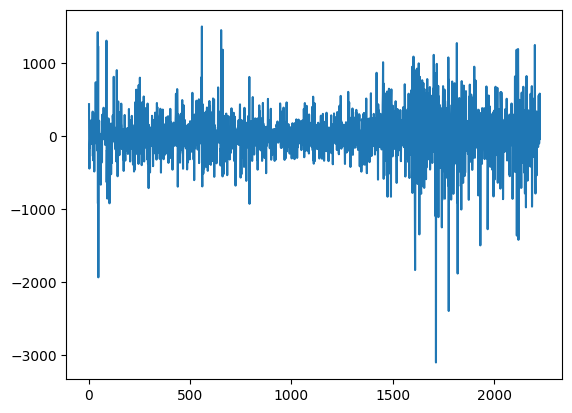

In [106]:
df1["Price First Difference"].plot()

In [104]:
df1["Price Seasonal First Difference"]=df1["Price"]-df1["Price"].shift(12)          #Price seasonal first difference

<Axes: >

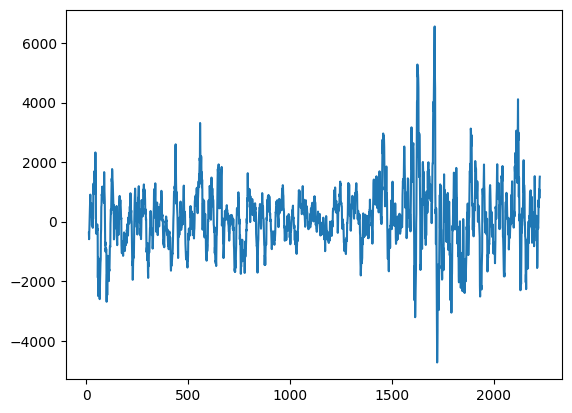

In [107]:
df1["Price Seasonal First Difference"].plot()

From this graph we have seen that the residuals are centered around zero with constant variance, supporting the assumption that they are random and normally distributed.

In [108]:
#again test dickey fuller test
adfuller_test(df1["Price Seasonal First Difference"].dropna())

ADF Test Statistic : -7.018545544607817
p-value : 6.634827836410394e-10
#Lags Used : 24
Number of Observations Used : 2190
strong evidence against the null hypothesis(Ho) reject the null hypothesis, Data has no unit root and is stationary


From above output, p value is <0.05, so it is stationary

# Auto correlation and partial auto correlation

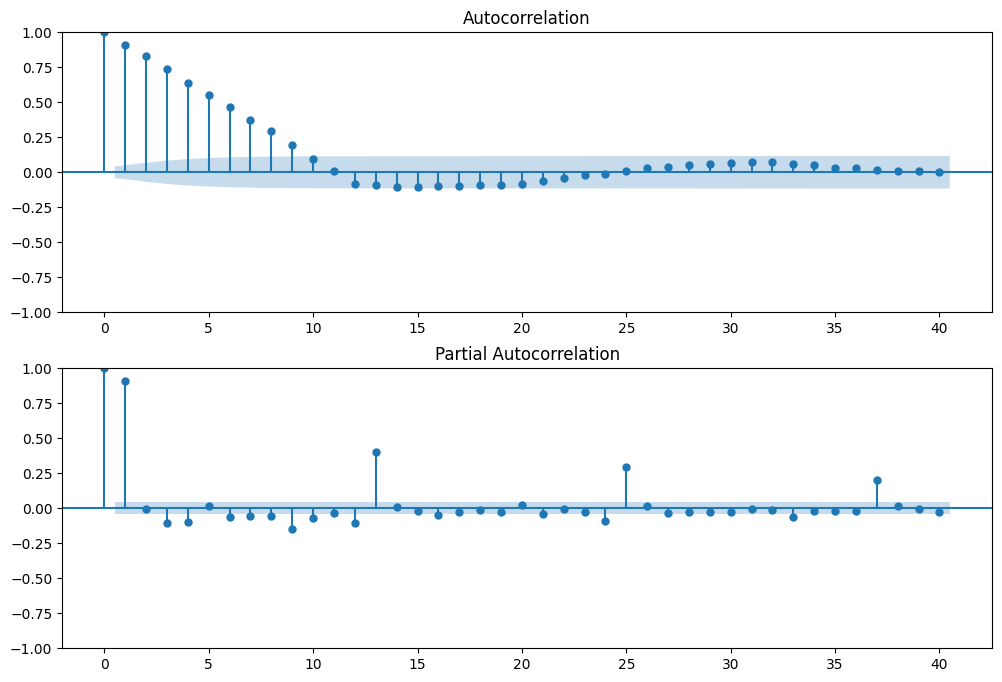

In [109]:
fig=plt.figure(figsize=(12,8))
ax1=fig.add_subplot(211)
fig=plot_acf(df1['Price Seasonal First Difference'].iloc[13:],lags=40,ax=ax1)
ax2=fig.add_subplot(212)
fig=plot_pacf(df1['Price Seasonal First Difference'].iloc[13:],lags=40,ax=ax2)

From above 2 graphs, we can say that p =2, q=11, d=1

In [76]:
# !pip install pmdarima
# from pmdarima.arima import auto_arima
# model=auto_arima(df['Price'],start_p=1,start_q=1,test='adf',max_p=3,max_q=3,m=12,start_P=0,seasonal=True,d=1,D=1,trace=True,error_action='ignore',suppress_warnings=True)
# model.fit


# ARIMA Model

In [110]:
# stasts model and arima
from statsmodels.tsa.arima.model import ARIMA
p,d,q=2,1,5

model=ARIMA(df['Price'],order=(p,d,q))
model=model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Price   No. Observations:                 2227
Model:                 ARIMA(2, 1, 5)   Log Likelihood              -16010.888
Date:                Tue, 02 Jul 2024   AIC                          32037.777
Time:                        11:27:10   BIC                          32083.440
Sample:                             0   HQIC                         32054.453
                               - 2227                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2965      0.234     -1.265      0.206      -0.756       0.163
ar.L2          0.5303      0.241      2.204      0.028       0.059       1.002
ma.L1          0.2615      0.236      1.106      0.269      -0.202       0.725
ma.L2         -0.5208      0.239     -2.175      0.030      -0.990      -0.051
ma.L3          0.0482      0.020      2.369      0.018       0.008       0.088
ma.L4         -0.0336      0.015     -2.197      0.028      -0.064      -0.004
ma.L5         -0.0540      0.016     -3.449      0.001      -0.085      -0.023
sigma2      1.039e+05   1610.009     64.536      0.000    1.01e+05    1.07e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):              6425.03
Prob(Q):                              0.71   Prob(JB):                         0.00
Heteroskedasticity (H):               2.58   Skew:                            -0.69
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

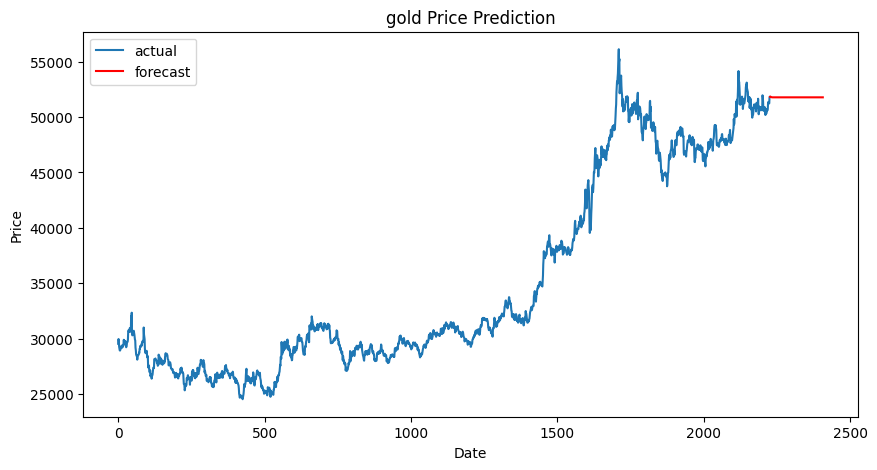

In [111]:
# predict the next 180 days
forecast=model.predict(start=len(df["Price"]),end=len(df["Price"])+180)
forecast

# plot forecast
plt.figure(figsize=(10,5))
plt.plot(df['Price'],label='actual')
plt.plot(forecast,color='red',label='forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('gold Price Prediction')
plt.legend()
plt.show()



In above plot, the red line indicates that the forecasting of next 180 days

# SARIMA Model

In [112]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

p,d,q=2,1,2
model=SARIMAX(df['Price'],order=(p,d,q),seasonal_order=(p,d,q,12))
results=model.fit()
print(results.summary())


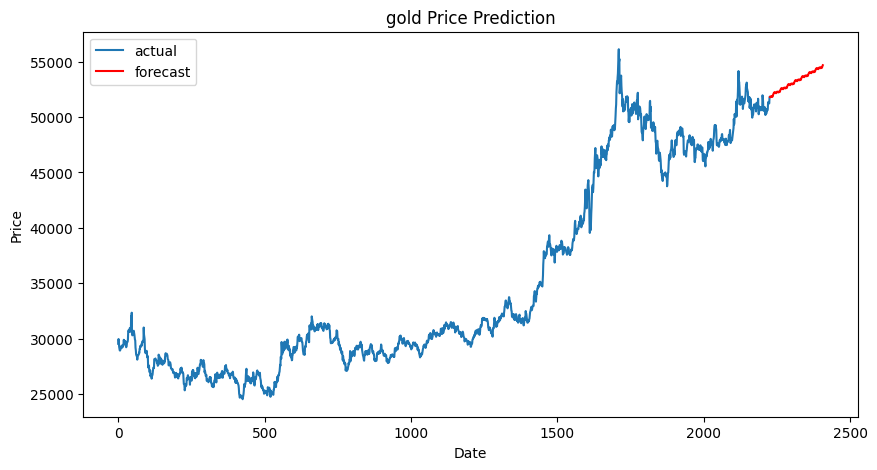

In [80]:
predictions=results.predict(start=len(df["Price"]),end=len(df["Price"])+180)

# plot the prediction
plt.figure(figsize=(10,5))
plt.plot(df['Price'],label='actual')
plt.plot(predictions,color="red",label='forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('gold Price Prediction')
plt.legend()
plt.show()

From above plot the red line indicates that forecasting of next 180 days

**Forecast Dataset**

In [82]:
df1.set_index("Date",inplace=True)

In [84]:

future_dates=[df1.index[-1]+ DateOffset(months=x)for x in range(0,24)]
future_dataset_df1=pd.DataFrame(index=future_dates[1:],columns=df1.columns)
future_df1=pd.concat([df1,future_dataset_df1])
future_df1['forecast'] = results.predict(start = 8, end = 12, dynamic= True)
future_df1.tail()

,Price,Price First Difference,Price Seasonal First Difference,forecast
2024-03-05,NaN,NaN,NaN,NaN
2024-04-05,NaN,NaN,NaN,NaN
2024-05-05,NaN,NaN,NaN,NaN
2024-06-05,NaN,NaN,NaN,NaN
2024-07-05,NaN,NaN,NaN,NaN



* The graph shows both the actual gold prices (in blue) and the forecasted gold prices (in red).

* The actual gold prices show an overall increasing trend with some fluctuations. Initially, prices were relatively stable with minor variations, but later, they exhibited significant upward movement.

* The gold prices have experienced periods of volatility, especially in the latter part of the graph where there are sharp rises and falls.

* Towards the end of the actual data, the gold prices have reached a high point, which is followed by a slight drop and then stabilization.

* The forecast (red line) continues the upward trend, indicating confidence in a continued increase in gold prices. However, as with any forecast, it should be interpreted with caution due to potential market uncertainties.

To improve the accuracy of future forecasts, consider experimenting with more advanced models such as Long Short-Term Memory (LSTM) networks, or Prophet. Additionally, perform further hyperparameter tuning and include more recent data to better capture the current market trends.